<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/1029%20%ED%96%89%EC%82%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%20%EB%AA%A8%EB%8D%B8%20(%EC%B5%9C%EC%A2%85%20%EC%BD%94%EB%93%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install --upgrade gensim

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from gensim.utils import simple_preprocess
import nltk
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# 데이터 가져오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DAB/행사_데이터/Olympic_final_1.csv', encoding = 'cp949').iloc[:,1:]
df

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,우리금융아트홀,문화예술행사,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012년,1월,겨울,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,핸드볼경기장,체육행사,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012년,1월,겨울,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,올림픽홀,대중공연,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,올림픽홀,대중공연,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,KSPO DOME(체조경기장),문화예술행사,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012년,1월,겨울,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,뮤즈라이브,문화예술행사,BoA콘서트,2023-03-11,2023-03-12,6000,4504,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,뮤즈라이브 문화예술행사 BoA콘서트 2023년 3월 봄 내부,1721.505796
1334,핸드볼경기장,문화예술행사,2023 윤하 앵콜 콘서트,2023-03-11,2023-03-12,8000,9493,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,핸드볼경기장 문화예술행사 2023 윤하 앵콜 콘서트 2023년 3월 봄 내부,5695.938805
1335,평화의광장,공공행사,2023 서울마라톤 겸 동아마라톤,2023-03-19,2023-03-19,10000,10000,외부,1,6,...,0,0,4671.767123,9046.742340,7098.186916,2023년,3월,봄,평화의광장 공공행사 2023 서울마라톤 겸 동아마라톤 2023년 3월 봄 외부,6640.384870
1336,KSPO DOME(체조경기장),문화예술행사,해리 스타일스 내한공연 (HARRY STYLES LIVE IN SEOUL),2023-03-20,2023-03-20,14000,15100,내부,1,0,...,0,0,4026.739130,19989.096150,7098.186916,2023년,3월,봄,KSPO DOME(체조경기장) 문화예술행사 해리 스타일스 내한공연 (HARRY ST...,11203.942690


# 예측

#### 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FCLTY_NM              1338 non-null   object 
 1   EVENT_SDIV_NM         1338 non-null   object 
 2   EVENT_NM              1338 non-null   object 
 3   RENTLSPCE_BEGIN_DE    1338 non-null   object 
 4   RENTLSPCE_END_DE      1338 non-null   object 
 5   REQST_EVENT_NMPR_CO   1338 non-null   int64  
 6   EXCCLC_EVENT_NMPR_CO  1338 non-null   int64  
 7   ISE_ELSE_FLAG_NM      1338 non-null   object 
 8   USE_DAY_CO            1338 non-null   int64  
 9   WEEKDAY_BEGIN         1338 non-null   int64  
 10  WEEKDAY_END           1338 non-null   int64  
 11  WEEKEND               1338 non-null   int64  
 12  HOLIDAY               1338 non-null   int64  
 13  YEAR_END              1338 non-null   int64  
 14  BEGIN_AVG_WEEKDAY     1338 non-null   float64
 15  END_AVG_WEEKDAY      

In [ ]:
df["FCLTY_NM"].value_counts()

올림픽홀                413
핸드볼경기장              240
KSPO DOME(체조경기장)    213
뮤즈라이브               104
우리금융아트홀              87
K-아트홀                71
평화의광장                48
88잔디마당               42
88호수수변무대             30
올림픽컨벤션센터             27
피크닉광장                15
핸드볼보조경기장             13
한얼광장                 13
기타                    9
만남의광장                 3
몽촌해자수변무대B             3
몽촌해자수변무대A             3
올림픽수영장                3
벨로드롬                  1
Name: FCLTY_NM, dtype: int64

In [ ]:
df.loc[df["FCLTY_NM"] == "올림픽홀","FCLTY_NM"] = 1
df.loc[df["FCLTY_NM"] == "핸드볼경기장","FCLTY_NM"] = 2
df.loc[df["FCLTY_NM"] == "KSPO DOME(체조경기장)","FCLTY_NM"] = 3
df.loc[df["FCLTY_NM"] == "뮤즈라이브","FCLTY_NM"] = 4
df.loc[df["FCLTY_NM"] == "우리금융아트홀","FCLTY_NM"] = 5
df.loc[df["FCLTY_NM"] == "K-아트홀","FCLTY_NM"] = 6
df.loc[df["FCLTY_NM"] == "평화의광장","FCLTY_NM"] = 7
df.loc[df["FCLTY_NM"] == "88잔디마당","FCLTY_NM"] = 8
df.loc[df["FCLTY_NM"] == "88호수수변무대","FCLTY_NM"] = 9
df.loc[df["FCLTY_NM"] == "올림픽컨벤션센터","FCLTY_NM"] = 10
df.loc[df["FCLTY_NM"] == "피크닉광장","FCLTY_NM"] = 11
df.loc[df["FCLTY_NM"] == "핸드볼보조경기장","FCLTY_NM"] = 12
df.loc[df["FCLTY_NM"] == "한얼광장","FCLTY_NM"] = 13
df.loc[df["FCLTY_NM"] == "기타","FCLTY_NM"] = 14
df.loc[df["FCLTY_NM"] == "만남의광장","FCLTY_NM"] = 15
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대B","FCLTY_NM"] = 16
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대A","FCLTY_NM"] = 17
df.loc[df["FCLTY_NM"] == "올림픽수영장","FCLTY_NM"] = 18
df.loc[df["FCLTY_NM"] == "벨로드롬","FCLTY_NM"] = 19

In [ ]:
df.loc[df["EVENT_SDIV_NM"] == "문화예술행사","EVENT_SDIV_NM"] = 1
df.loc[df["EVENT_SDIV_NM"] == "대중공연","EVENT_SDIV_NM"] = 2
df.loc[df["EVENT_SDIV_NM"] == "체육행사","EVENT_SDIV_NM"] = 3
df.loc[df["EVENT_SDIV_NM"] == "공공행사","EVENT_SDIV_NM"] = 4
df.loc[df["EVENT_SDIV_NM"] == "순수예술공연","EVENT_SDIV_NM"] = 5

- 12월, 1월, 2월: 겨울 (1)
- 3월, 4월, 5월: 봄 (2)
- 6월, 7월, 8월: 여름 (3)
- 9월, 10월, 11월: 가을 (4)

In [ ]:
df["계절"] = 0

In [ ]:
# 년도에서 숫자만 출력
df['년도'] = df['년도'].str.extract(r'(\d+)')

In [ ]:
# 월에서 숫자만 출력
df['월'] = df['월'].str.extract(r'(\d+)')

In [ ]:
df = df.astype({'년도':'int','월':'int'})

In [ ]:
df.loc[(df["월"] == 12) | (df["월"] == 1) | (df["월"] == 2),"계절"] = 1
df.loc[(df["월"] == 3) | (df["월"] == 4) | (df["월"] == 5),"계절"] = 2
df.loc[(df["월"] == 6) | (df["월"] == 7) | (df["월"] == 8),"계절"] = 3
df.loc[(df["월"] == 9) | (df["월"] == 10) | (df["월"] == 11),"계절"] = 4

In [ ]:
df["계절"] = df["계절"].astype('category')
df["FCLTY_NM"] = df["FCLTY_NM"].astype('category')
df["EVENT_SDIV_NM"] = df["EVENT_SDIV_NM"].astype('category')
df["ISE_ELSE_FLAG_NM"] = df["ISE_ELSE_FLAG_NM"].astype('category')
df["WEEKDAY_BEGIN"] = df["WEEKDAY_BEGIN"].astype('category')
df["WEEKDAY_END"] = df["WEEKDAY_END"].astype('category')
df["WEEKEND"] = df["WEEKEND"].astype('category')
df["HOLIDAY"] = df["HOLIDAY"].astype('category')
df["YEAR_END"] = df["YEAR_END"].astype('category')
df.년도 = df.년도.astype('category')

In [ ]:
df.head()

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,5,1,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012,1,1,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,2,3,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012,1,1,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,1,2,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012,1,1,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,1,2,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012,1,1,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,3,1,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012,1,1,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512


#### Dataset 나누기

In [ ]:
# df_pred
X_1 = df.iloc[:,[0,1,5,8,21]].values
y_1 = df["EXCCLC_EVENT_NMPR_CO"].values

In [ ]:
# train & test set 분할
from sklearn.model_selection import train_test_split

# 8:2로 test train set 나누기
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle=True)

In [ ]:
# df_pred
X_2 = df.iloc[:,[0,5,8,12,15,17,18,19,21]].values
y_2 = df["EXCCLC_EVENT_NMPR_CO"].values

# 8:2로 test train set 나누기
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size = 0.2, shuffle=True)

#### Model 2 (회귀분석)
- 변수: 공연장소, 공연유형, 신청인원, 사용일수, vector3_col
- vector3_col: vector3 함수를 이용해 도출한 유사공연의 정산인원

In [ ]:
df_train1 = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)], axis=1)
df_train1.columns = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train1

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,9.0,1.0,1966.0,2.0,3958.311676,1901
1,1.0,2.0,3500.0,1.0,2765.611978,3000
2,12.0,1.0,9000.0,3.0,5673.569295,12451
3,1.0,1.0,6000.0,2.0,4898.711554,5708
4,3.0,4.0,12000.0,1.0,9172.349168,10000
...,...,...,...,...,...,...
851,1.0,1.0,4360.0,2.0,3120.093122,4360
852,4.0,1.0,200.0,1.0,2471.617526,174
853,2.0,3.0,1000.0,3.0,2706.493720,900
854,1.0,2.0,2000.0,1.0,2623.634222,1285


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_reg1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_train1).fit()
model_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.658
Model:                              OLS   Adj. R-squared:                  0.648
Method:                   Least Squares   F-statistic:                     63.95
Date:                  Sun, 29 Oct 2023   Prob (F-statistic):          2.79e-174
Time:                          13:35:43   Log-Likelihood:                -9347.9
No. Observations:                   856   AIC:                         1.875e+04
Df Residuals:                       830   BIC:                         1.887e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                3333.5210   1422.577      2.343      0.019     541.249    6125.792
C(FCLTY_NM)[T.2.0]       1536.5265   1833.692      0.838      0.402   -2062.693    5135.746
C(FCLTY_NM)[T.3.0]       1.108e+04   1878.075      5.900      0.000    7394.655    1.48e+04
C(FCLTY_NM)[T.4.0]      -2823.3150   2134.985     -1.322      0.186   -7013.920    1367.290
C(FCLTY_NM)[T.5.0]       -171.1494   2184.424     -0.078      0.938   -4458.794    4116.496
C(FCLTY_NM)[T.6.0]      -2579.8328   2249.414     -1.147      0.252   -6995.041    1835.375
C(FCLTY_NM)[T.7.0]      -3515.6992   4043.362     -0.869      0.385   -1.15e+04    4420.718
C(FCLTY_NM)[T.8.0]       6158.5133   2911.909      2.115      0.035     442.941    1.19e+04
C(FCLTY_NM)[T.9.0]       -366.4950   3281.380     -0.112      0.911   -6807.273    6074.283
C(FCLTY_NM)[T.10.0]     -4982.1106   3426.370     -1.454      0.146   -1.17e+04    1743.259
C(FCLTY_NM)[T.11.0]      4116.2734   5411.368      0.761      0.447   -6505.301    1.47e+04
C(FCLTY_NM)[T.12.0]      1198.5440   5032.731      0.238      0.812   -8679.833    1.11e+04
C(FCLTY_NM)[T.13.0]      5080.7696   6335.928      0.802      0.423   -7355.556    1.75e+04
C(FCLTY_NM)[T.14.0]      4932.7623   6111.484      0.807      0.420   -7063.020    1.69e+04
C(FCLTY_NM)[T.15.0]      8797.9925   1.02e+04      0.866      0.387   -1.11e+04    2.87e+04
C(FCLTY_NM)[T.16.0]      5054.3449   1.02e+04      0.497      0.619   -1.49e+04     2.5e+04
C(FCLTY_NM)[T.17.0]      1.456e+05   9021.387     16.144      0.000    1.28e+05    1.63e+05
C(FCLTY_NM)[T.18.0]      2121.0701   8246.555      0.257      0.797   -1.41e+04    1.83e+04
C(FCLTY_NM)[T.19.0]       445.1652   1.38e+04      0.032      0.974   -2.67e+04    2.76e+04
C(EVENT_SDIV_NM)[T.2.0]  -287.1090   1511.669     -0.190      0.849   -3254.252    2680.034
C(EVENT_SDIV_NM)[T.3.0] -3635.7593   2211.686     -1.644      0.101   -7976.916     705.397
C(EVENT_SDIV_NM)[T.4.0] -6054.0810   3010.053     -2.011      0.045    -1.2e+04    -145.871
C(EVENT_SDIV_NM)[T.5.0]  -325.2820   4495.643     -0.072      0.942   -9149.449    8498.885
REQST_EVENT_NMPR_CO         0.3889      0.016     24.714      0.000       0.358       0.420
USE_DAY_CO                214.9335     88.741      2.422      0.016      40.750     389.117
유사공연_가중평균                  -0.2218      0.078     -2.852      0.004      -0.374      -0.069
==============================================================================
Omnibus:                      830.611   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1019999.359
Skew:                           3.267   Prob(JB):                         0.00
Kurtosis:                     171.983   Cond. No.                     1.08e+0

In [ ]:
x_cols = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균"]

test_df

In [ ]:
df_test1 = pd.concat([pd.DataFrame(X_test1),pd.DataFrame(y_test1)], axis=1)
df_test1.columns = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2(index,df):
  result = model_reg1.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
df_test1 = df_test1[df_test1["FCLTY_NM"] != 19.0]

In [ ]:
model_reg1.predict(df_test1[x_cols])

0        727.863878
1      13622.356741
2       4204.261204
3      17643.026930
4       5686.466994
           ...     
263     8611.521951
264      793.911530
265     5799.049298
266    11068.579513
267     4355.485896
Length: 268, dtype: float64

In [ ]:
score2_df = pd.DataFrame([df_test1["EXCCLC_EVENT_NMPR_CO"],model_reg1.predict(df_test1[x_cols])],index=["test","predict"]).transpose()
score2_df

,test,predict
0,3855.0,727.863878
1,11120.0,13622.356741
2,2153.0,4204.261204
3,11013.0,17643.026930
4,8450.0,5686.466994
...,...,...
263,5497.0,8611.521951
264,1173.0,793.911530
265,4826.0,5799.049298
266,12000.0,11068.579513


In [ ]:
from matplotlib import pyplot as plt

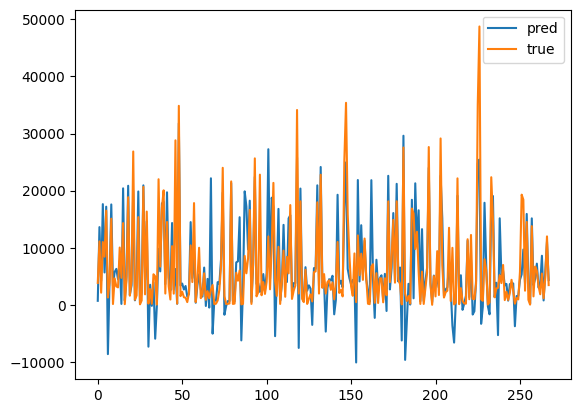

In [ ]:
plt.plot(np.array(model_reg1.predict(df_test1[x_cols])),label = "pred")
plt.plot(np.array(df_test1["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test1["EXCCLC_EVENT_NMPR_CO"], model_reg1.predict(df_test1[x_cols]))

26507036.80945322

#### Model 2_1 (회귀분석)
- 변수: FCLTY_NM_cluster, 공연유형, 신청인원, 사용일수,vector3_col,
- 공연장소별 정산인원 평균을 내서 군집 4개로 만들고자 함.

공연장소별 정산인원 평균- 3개정도로 줄이기 > makeprediction2 적용해보기

- 공연장소  올림픽홀 (1), 핸드볼경기장 (2), KSPO DOME(체조경기장) (3), 뮤즈라이브 (4), 우리금융아트홀 (5),  K-아트홀 (6), 평화의광장 (7), 88잔디마당 (8), 88호수수변무대 (9), 올림픽컨벤션센터 (10), 피크닉광장 (11), 핸드볼보조경기장 (12), 한얼광장 (13), 기타 (14), 만남의광장 (15), 몽촌해자수변무대B (16), 몽촌해자수변무대A (17), 올림픽수영장 (18), 벨로드롬 (19)

In [ ]:
df_train1.groupby(['FCLTY_NM'], as_index=False).mean()["EXCCLC_EVENT_NMPR_CO"].sort_values(ascending = False)

# 10000명, 5000명, 1000명을 기준선으로 적용
# 16에 대한 평균값이 이상하게 크게 나와서 직접 계산하여 적용
# 1 (2,7,12)/ 2 (6,4,14,1)/ 3 (0,8,17,9,13,11,15,16,5)/ 4 (10,3,18)

16    220400.000000
2      19687.654135
7      14395.428571
12     10431.000000
6       8738.034483
14      8000.000000
4       6917.826923
1       5203.231707
0       4465.166667
13      2985.714286
9       2891.222222
17      2666.666667
15      2250.000000
11      2150.111111
8       2113.857143
5       1097.531915
10       487.000000
3        366.234375
18        30.000000
Name: EXCCLC_EVENT_NMPR_CO, dtype: float64

In [ ]:
df_new = df_train1.copy()

# 1~4 군집 중 어디에 속하는 지
df_new["FCLTY_NM_cluster"] = 0
df_new.loc[(df_new["FCLTY_NM"]== 2) | (df_new["FCLTY_NM"]== 7) | (df_new["FCLTY_NM"]== 12), "FCLTY_NM_cluster"] = 1
df_new.loc[(df_new["FCLTY_NM"]== 6) | (df_new["FCLTY_NM"]== 4) | (df_new["FCLTY_NM"]== 14) | (df_new["FCLTY_NM"]== 1),"FCLTY_NM_cluster"] = 2
df_new.loc[(df_new["FCLTY_NM"]== 0) | (df_new["FCLTY_NM"]== 8) | (df_new["FCLTY_NM"]== 17) | (df_new["FCLTY_NM"]== 9) | (df_new["FCLTY_NM"]== 13) | (df_new["FCLTY_NM"]== 11) | (df_new["FCLTY_NM"]== 15)| (df_new["FCLTY_NM"]== 16) | (df_new["FCLTY_NM"]== 5),"FCLTY_NM_cluster"] = 3
df_new.loc[(df_new["FCLTY_NM"]== 10) | (df_new["FCLTY_NM"]== 3) | (df_new["FCLTY_NM"]== 18),"FCLTY_NM_cluster"] = 4
df_new

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO,FCLTY_NM_cluster
0,9.0,1.0,1966.0,2.0,3958.311676,1901,3
1,1.0,2.0,3500.0,1.0,2765.611978,3000,2
2,12.0,1.0,9000.0,3.0,5673.569295,12451,1
3,1.0,1.0,6000.0,2.0,4898.711554,5708,2
4,3.0,4.0,12000.0,1.0,9172.349168,10000,4
...,...,...,...,...,...,...,...
851,1.0,1.0,4360.0,2.0,3120.093122,4360,2
852,4.0,1.0,200.0,1.0,2471.617526,174,2
853,2.0,3.0,1000.0,3.0,2706.493720,900,1
854,1.0,2.0,2000.0,1.0,2623.634222,1285,2


In [ ]:
model_reg1_new = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM_cluster)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_new).fit()
model_reg1_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.530
Model:                              OLS   Adj. R-squared:                  0.524
Method:                   Least Squares   F-statistic:                     86.58
Date:                  Sun, 29 Oct 2023   Prob (F-statistic):          2.71e-130
Time:                          13:35:47   Log-Likelihood:                -9484.2
No. Observations:                   856   AIC:                         1.899e+04
Df Residuals:                       844   BIC:                         1.905e+04
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1849.5200    1.6e+04      0.116      0.908   -2.95e+04    3.32e+04
C(FCLTY_NM_cluster)[T.1]   537.0824   1.59e+04      0.034      0.973   -3.07e+04    3.18e+04
C(FCLTY_NM_cluster)[T.2]  1884.9797    1.6e+04      0.118      0.906   -2.95e+04    3.33e+04
C(FCLTY_NM_cluster)[T.3]  6758.9335    1.6e+04      0.421      0.673   -2.47e+04    3.82e+04
C(FCLTY_NM_cluster)[T.4]  9717.2228    1.6e+04      0.606      0.544   -2.17e+04    4.12e+04
C(EVENT_SDIV_NM)[T.2.0]  -2051.5771   1435.314     -1.429      0.153   -4868.781     765.627
C(EVENT_SDIV_NM)[T.3.0]  -1490.2991   2399.632     -0.621      0.535   -6200.245    3219.647
C(EVENT_SDIV_NM)[T.4.0]  -2419.3852   2112.655     -1.145      0.252   -6566.060    1727.290
C(EVENT_SDIV_NM)[T.5.0]  -2991.5773   4914.002     -0.609      0.543   -1.26e+04    6653.521
REQST_EVENT_NMPR_CO          0.4743      0.017     27.816      0.000       0.441       0.508
USE_DAY_CO                  23.5122     96.001      0.245      0.807    -164.916     211.941
유사공연_가중평균                   -0.2397      0.087     -2.750      0.006      -0.411      -0.069
==============================================================================
Omnibus:                     1298.355   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2882008.773
Skew:                           7.909   Prob(JB):                         0.00
Kurtosis:                     286.820   Cond. No.                     2.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2_2 (회귀분석)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
df_train2 = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)], axis=1)
df_train2.columns = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train2

,FCLTY_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,HOLIDAY,END_AVG_WEEKDAY,년도,월,계절,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,13.0,12496.0,2.0,1.0,3046.842105,2013.0,8.0,3.0,8677.105014,12496
1,1.0,14800.0,5.0,0.0,6651.437500,2019.0,12.0,1.0,4399.741669,12665
2,1.0,10000.0,3.0,0.0,9046.742340,2021.0,7.0,3.0,5795.214783,8479
3,3.0,13000.0,2.0,0.0,9046.742340,2016.0,3.0,2.0,23780.512950,14550
4,6.0,5423.0,24.0,1.0,9046.742340,2017.0,12.0,1.0,1297.728141,5640
...,...,...,...,...,...,...,...,...,...,...
851,4.0,237.0,1.0,0.0,9046.742340,2015.0,12.0,1.0,1916.276531,174
852,1.0,5200.0,2.0,0.0,9046.742340,2019.0,1.0,1.0,2433.174219,4159
853,6.0,300.0,1.0,0.0,3467.288401,2018.0,6.0,3.0,4581.415580,521
854,6.0,220.0,1.0,0.0,3467.288401,2019.0,1.0,1.0,683.598288,240


In [ ]:
model_reg2 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+C(HOLIDAY)+END_AVG_WEEKDAY+C(년도)+C(월)+C(계절)+유사공연_가중평균',data= df_train2).fit()
model_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.950
Model:                              OLS   Adj. R-squared:                  0.947
Method:                   Least Squares   F-statistic:                     339.8
Date:                  Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                          13:35:49   Log-Likelihood:                -8513.9
No. Observations:                   856   AIC:                         1.712e+04
Df Residuals:                       810   BIC:                         1.734e+04
Df Model:                            45                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2123.4946   1108.970     -1.915      0.056   -4300.289      53.300
C(FCLTY_NM)[T.2.0]   -141.3593    536.583     -0.263      0.792   -1194.617     911.899
C(FCLTY_NM)[T.3.0]   6102.4650    689.339      8.853      0.000    4749.363    7455.567
C(FCLTY_NM)[T.4.0]  -1285.8585    745.299     -1.725      0.085   -2748.803     177.086
C(FCLTY_NM)[T.5.0]     71.5694    821.630      0.087      0.931   -1541.206    1684.345
C(FCLTY_NM)[T.6.0]  -1853.1953    885.676     -2.092      0.037   -3591.686    -114.704
C(FCLTY_NM)[T.7.0]     83.9697   1042.535      0.081      0.936   -1962.419    2130.358
C(FCLTY_NM)[T.8.0]   1470.2130   1172.437      1.254      0.210    -831.161    3771.587
C(FCLTY_NM)[T.9.0]   -851.2325   1283.946     -0.663      0.508   -3371.486    1669.021
C(FCLTY_NM)[T.10.0] -3473.3897   1463.418     -2.373      0.018   -6345.929    -600.850
C(FCLTY_NM)[T.11.0] -1423.6940   1740.073     -0.818      0.413   -4839.278    1991.890
C(FCLTY_NM)[T.12.0] -2572.2600   2028.732     -1.268      0.205   -6554.452    1409.932
C(FCLTY_NM)[T.13.0]  2334.9155   1836.991      1.271      0.204   -1270.909    5940.740
C(FCLTY_NM)[T.14.0] -1711.1506   2206.188     -0.776      0.438   -6041.671    2619.369
C(FCLTY_NM)[T.15.0] -1136.7868   3733.590     -0.304      0.761   -8465.439    6191.865
C(FCLTY_NM)[T.16.0]  -880.4845   3115.325     -0.283      0.778   -6995.547    5234.578
C(FCLTY_NM)[T.17.0]  3.093e+05   1.24e+04     24.848      0.000    2.85e+05    3.34e+05
C(FCLTY_NM)[T.18.0]   921.1461   3104.203      0.297      0.767   -5172.084    7014.377
C(FCLTY_NM)[T.19.0]   866.0766   5284.428      0.164      0.870   -9506.712    1.12e+04
C(HOLIDAY)[T.1.0]    -732.0912    744.912     -0.983      0.326   -2194.277     730.094
C(년도)[T.2013.0]       180.6908    854.593      0.211      0.833   -1496.788    1858.169
C(년도)[T.2014.0]       911.3260    863.270      1.056      0.291    -783.184    2605.836
C(년도)[T.2015.0]       268.2398    824.139      0.325      0.745   -1349.461    1885.940
C(년도)[T.2016.0]      1873.9930    818.584      2.289      0.022     267.198    3480.788
C(년도)[T.2017.0]      2439.1071    876.858      2.782      0.006     717.925    4160.289
C(년도)[T.2018.0]      1014.2795    792.837      1.279      0.201    -541.978    2570.537
C(년도)[T.2019.0]      2267.6573    778.929      2.911      0.004     738.700    3796.614
C(년도)[T.2020.0]      2203.0510   1674.528      1.316      0.189   -1083.874    5489.976
C(년도)[T.2021.0]      -603.8448   1297.565     -0.465      0.642   -3150.831    1943.141
C(년도)[T.2022.0]      1117.9773    875.807      1.277      0.202    -601.142    2837.097
C(년도)[T.2023.0]      1287.5656   1639.678      0.785      0.433   -1930.953    4506.084
C(월)[T.2.0]          -854.3792   1045.596     -0.817      0.414   -29

In [ ]:
x_cols = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균"]

df_test2

In [ ]:
df_test2 = pd.concat([pd.DataFrame(X_test2),pd.DataFrame(y_test2)], axis=1)
df_test2.columns = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_test2

,FCLTY_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,HOLIDAY,END_AVG_WEEKDAY,년도,월,계절,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,10.0,10500.0,65.0,1.0,9046.742340,2014.0,6.0,3.0,2623.750167,9821
1,1.0,6500.0,2.0,0.0,9046.742340,2015.0,3.0,2.0,3292.277146,6600
2,7.0,2000.0,1.0,0.0,9046.742340,2016.0,9.0,4.0,3121.787892,2000
3,3.0,21000.0,2.0,0.0,9046.742340,2016.0,2.0,1.0,8846.060244,20028
4,12.0,1000.0,9.0,0.0,6651.437500,2019.0,4.0,2.0,829.246243,3300
...,...,...,...,...,...,...,...,...,...,...
263,1.0,5000.0,2.0,0.0,9046.742340,2019.0,5.0,2.0,16748.544530,13373
264,3.0,22000.0,2.0,0.0,9046.742340,2019.0,6.0,3.0,10961.226290,14619
265,1.0,2000.0,1.0,0.0,5102.242857,2018.0,10.0,4.0,3217.990911,2380
266,9.0,100.0,1.0,1.0,19989.096150,2016.0,10.0,4.0,2796.615580,100


In [ ]:
df_test2 = df_test2[df_test2["FCLTY_NM"] != 19.0]

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2_1(index,df):
  result = model_reg2.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
model_reg2.predict(df_test2[x_cols])

score2_2_df = pd.DataFrame([df_test2["EXCCLC_EVENT_NMPR_CO"],model_reg2.predict(df_test2[x_cols])],index=["test","predict"]).transpose()
score2_2_df

,test,predict
0,9821.0,9563.312320
1,6600.0,4198.333272
2,2000.0,2701.768254
3,20028.0,18700.860409
4,3300.0,648.909576
...,...,...
263,13373.0,7743.031308
264,14619.0,21237.633755
265,2380.0,1965.284341
266,100.0,2761.162916


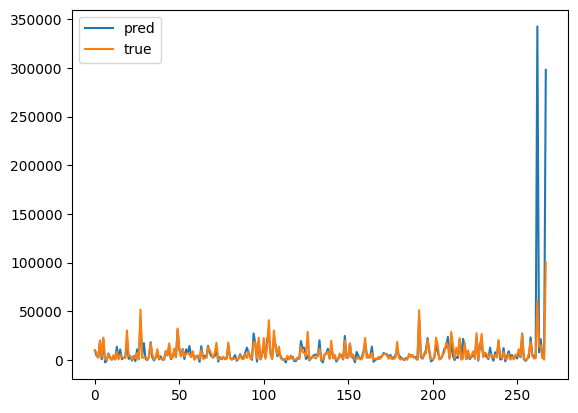

In [ ]:
plt.plot(np.array(model_reg2.predict(df_test2[x_cols])),label = "pred")
plt.plot(np.array(df_test2["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

In [ ]:
mean_squared_error(df_test2["EXCCLC_EVENT_NMPR_CO"], model_reg2.predict(df_test2[x_cols]))

459238056.1972228

#### Model 3_1 (ANN)
- 변수:  공연장소, 공연유형, 신청인원, 사용일수, vector3_col

Buiding ANN

In [ ]:
import tensorflow as tf

In [ ]:
ann1 = tf.keras.models.Sequential()

In [ ]:
ann1.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=6, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann1.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model_ann1 = ann1.fit(X_train1, y_train1, batch_size = 32, epochs = 25,validation_data=(X_val1, y_val1), shuffle=True)

Epoch 1/25
27/27 [==============================] - 1s 9ms/step - loss: 455787488.0000 - mean_squared_logarithmic_error: 1.7074 - val_loss: 59019332.0000 - val_mean_squared_logarithmic_error: 1.6999
Epoch 2/25
27/27 [==============================] - 0s 5ms/step - loss: 432786272.0000 - mean_squared_logarithmic_error: 1.5893 - val_loss: 54887028.0000 - val_mean_squared_logarithmic_error: 1.6366
Epoch 3/25
27/27 [==============================] - 0s 4ms/step - loss: 410443840.0000 - mean_squared_logarithmic_error: 1.5216 - val_loss: 51535436.0000 - val_mean_squared_logarithmic_error: 1.5736
Epoch 4/25
27/27 [==============================] - 0s 4ms/step - loss: 397145248.0000 - mean_squared_logarithmic_error: 1.4560 - val_loss: 47280840.0000 - val_mean_squared_logarithmic_error: 1.5213
Epoch 5/25
27/27 [==============================] - 0s 4ms/step - loss: 379586208.0000 - mean_squared_logarithmic_error: 1.4045 - val_loss: 44182844.0000 - val_mean_squared_logarithmic_error: 1.4701
Epoch

In [ ]:
# test set으로 예측 평가

y_pred1 = ann1.predict(X_test1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_test1.reshape(len(y_test1),1)),1))

9/9 [==============================] - 0s 2ms/step
[[3.38e+03 3.86e+03]
 [1.55e+04 1.11e+04]
 [3.12e+03 2.15e+03]
 [1.80e+04 1.10e+04]
 [5.77e+03 8.45e+03]
 [1.64e+04 1.65e+04]
 [5.42e+03 1.30e+03]
 [9.77e+02 4.04e+03]
 [1.14e+04 1.51e+04]
 [3.59e+02 1.64e+02]
 [3.65e+03 4.65e+03]
 [7.20e+03 3.25e+03]
 [4.13e+03 3.08e+03]
 [6.69e+03 1.00e+04]
 [6.03e+03 4.75e+03]
 [8.45e+03 1.43e+04]
 [1.77e+02 1.40e+02]
 [4.95e+03 4.38e+03]
 [1.34e+04 1.89e+04]
 [3.77e+03 1.63e+03]
 [5.27e+03 4.22e+03]
 [2.51e+04 2.69e+04]
 [1.71e+03 9.00e+02]
 [2.36e+03 1.67e+03]
 [8.71e+03 1.54e+04]
 [6.08e+02 1.10e+02]
 [3.11e+03 8.00e+02]
 [1.27e+04 2.07e+04]
 [3.38e+03 1.86e+03]
 [1.94e+04 1.63e+04]
 [1.59e+03 2.40e+02]
 [3.14e+03 2.79e+03]
 [1.13e+03 2.10e+02]
 [2.44e+03 5.37e+03]
 [5.07e+03 5.00e+03]
 [9.45e+02 7.00e+01]
 [1.71e+04 2.20e+04]
 [1.97e+03 6.72e+03]
 [1.57e+04 1.70e+04]
 [1.75e+04 2.01e+04]
 [2.31e+03 2.00e+03]
 [2.54e+04 1.45e+04]
 [3.65e+03 3.28e+03]
 [1.87e+03 9.50e+02]
 [9.43e+03 1.03e+04]
 [2.

In [ ]:
import sklearn.metrics

evs_no=sklearn.metrics.explained_variance_score(y_test1,ann1.predict(X_test1))
mse_no=sklearn.metrics.mean_squared_error(y_test1,ann1.predict(X_test1))
msle_no=sklearn.metrics.mean_squared_log_error(y_test1,ann1.predict(X_test1))
r2_no=sklearn.metrics.r2_score(y_test1,ann1.predict(X_test1))

9/9 [==============================] - 0s 2ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.6489081222600693
Mean Square Error       : 23231523.06463137
Mean Squared Log Error  : 0.689562425464879
R2 Score                : 0.6385887253640494


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


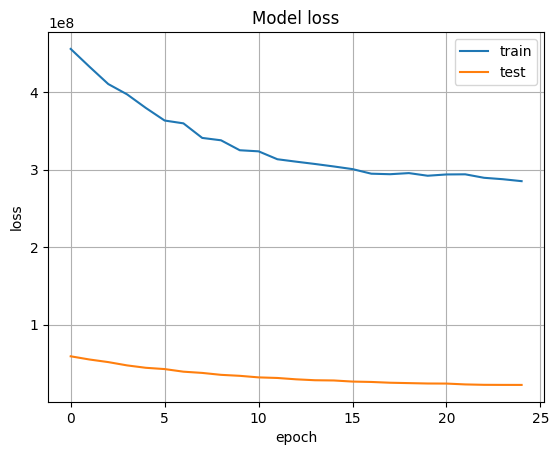

In [ ]:
# list all data in history
print(model_ann1.history.keys())
plt.plot(model_ann1.history['loss'])
plt.plot(model_ann1.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

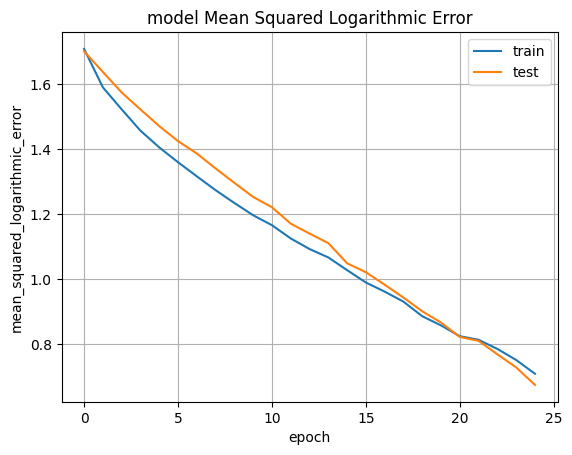

In [ ]:
# summarize history for loss
plt.plot(model_ann1.history['mean_squared_logarithmic_error'])
plt.plot(model_ann1.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred1)], axis=1)
score3_df.columns = ["test","predict"]
score3_df

,test,predict
0,3855,3379.473389
1,11120,15534.387695
2,2153,3123.132812
3,11013,18006.960938
4,8450,5766.409180
...,...,...
263,5497,5817.785156
264,1173,801.284912
265,4826,4485.551758
266,12000,9786.758789


#### Model 3_2 (ANN)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
ann2 = tf.keras.models.Sequential()
ann2.add(tf.keras.layers.Dense(units=4, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann2.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])
model_ann2 = ann2.fit(X_train2, y_train2, batch_size = 32, epochs = 25,validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/25
27/27 [==============================] - 1s 9ms/step - loss: 649459392.0000 - mean_squared_logarithmic_error: 64.7686 - val_loss: 216111168.0000 - val_mean_squared_logarithmic_error: 68.5803
Epoch 2/25
27/27 [==============================] - 0s 4ms/step - loss: 641593024.0000 - mean_squared_logarithmic_error: 64.5828 - val_loss: 210562416.0000 - val_mean_squared_logarithmic_error: 68.3674
Epoch 3/25
27/27 [==============================] - 0s 4ms/step - loss: 635195904.0000 - mean_squared_logarithmic_error: 64.3529 - val_loss: 204942176.0000 - val_mean_squared_logarithmic_error: 68.1313
Epoch 4/25
27/27 [==============================] - 0s 4ms/step - loss: 628061504.0000 - mean_squared_logarithmic_error: 64.1182 - val_loss: 201015024.0000 - val_mean_squared_logarithmic_error: 67.8899
Epoch 5/25
27/27 [==============================] - 0s 3ms/step - loss: 622633408.0000 - mean_squared_logarithmic_error: 63.8511 - val_loss: 195655216.0000 - val_mean_squared_logarithmic_error

test set으로 예측 평가

In [ ]:
y_pred2 = ann2.predict(X_test2)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred2.reshape(len(y_pred2),1), y_test2.reshape(len(y_test2),1)),1))

9/9 [==============================] - 0s 2ms/step
[[7.16e-01 9.82e+03]
 [7.16e-01 6.60e+03]
 [7.16e-01 2.00e+03]
 [3.53e+01 2.00e+04]
 [7.16e-01 3.30e+03]
 [8.01e+01 2.28e+04]
 [7.16e-01 3.70e+02]
 [7.16e-01 1.03e+02]
 [7.16e-01 5.55e+03]
 [7.16e-01 1.52e+03]
 [7.16e-01 5.00e+01]
 [7.16e-01 4.90e+03]
 [7.16e-01 2.30e+02]
 [7.16e-01 8.23e+03]
 [7.16e-01 6.00e+02]
 [7.16e-01 5.00e+03]
 [7.16e-01 2.90e+03]
 [7.16e-01 1.72e+03]
 [7.16e-01 2.22e+03]
 [1.61e+02 3.02e+04]
 [7.16e-01 4.27e+03]
 [7.16e-01 4.00e+03]
 [7.16e-01 1.10e+02]
 [7.16e-01 3.02e+03]
 [7.16e-01 1.53e+03]
 [1.14e+01 6.99e+03]
 [7.16e-01 4.00e+02]
 [8.62e+02 5.15e+04]
 [7.16e-01 1.86e+03]
 [1.81e+02 2.50e+03]
 [7.16e-01 2.81e+03]
 [7.16e-01 3.50e+02]
 [7.16e-01 2.65e+03]
 [7.16e-01 1.70e+04]
 [7.16e-01 5.90e+03]
 [7.16e-01 2.67e+02]
 [7.16e-01 1.80e+03]
 [7.16e-01 1.10e+04]
 [7.16e-01 1.39e+03]
 [7.16e-01 1.28e+03]
 [7.16e-01 1.00e+03]
 [7.16e-01 1.20e+02]
 [7.16e-01 9.16e+03]
 [7.16e-01 4.83e+03]
 [7.16e-01 1.69e+04]
 [7.

In [ ]:
evs_no=sklearn.metrics.explained_variance_score(y_test2,ann2.predict(X_test2))
mse_no=sklearn.metrics.mean_squared_error(y_test2,ann2.predict(X_test2))
msle_no=sklearn.metrics.mean_squared_log_error(y_test2,ann2.predict(X_test2))
r2_no=sklearn.metrics.r2_score(y_test2,ann2.predict(X_test2))

9/9 [==============================] - 0s 2ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.06522658540893478
Mean Square Error       : 148626864.09318265
Mean Squared Log Error  : 47.58999292132507
R2 Score                : -0.3425090691757351


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


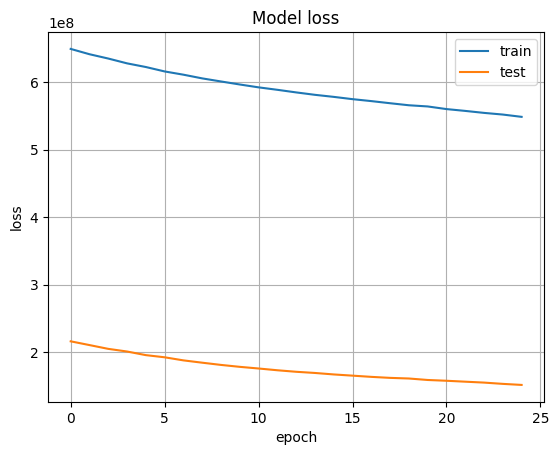

In [ ]:
# list all data in history
print(model_ann2.history.keys())
plt.plot(model_ann2.history['loss'])
plt.plot(model_ann2.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

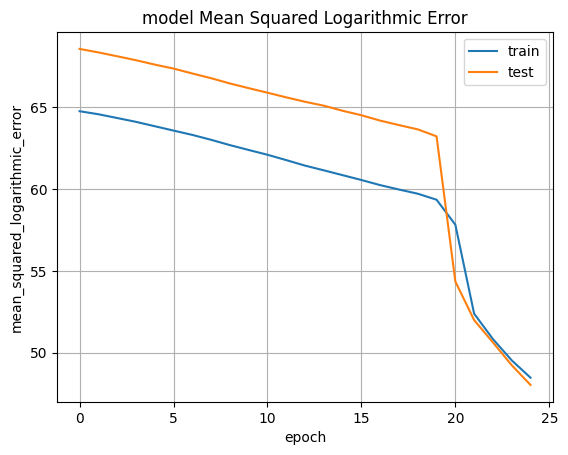

In [ ]:
# summarize history for loss
plt.plot(model_ann2.history['mean_squared_logarithmic_error'])
plt.plot(model_ann2.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred2)], axis=1)
score3_df.columns = ["test","predict"]
score3_df

,test,predict
0,9821,0.716335
1,6600,0.716335
2,2000,0.716335
3,20028,35.339855
4,3300,0.716335
...,...,...
263,13373,0.716335
264,14619,54.430763
265,2380,0.716335
266,100,0.716335


#### Model 4_1 (Ridge, Lasso)
- 변수: 공연장소, 공연유형, 신청인원,사용일수, vector3_col

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train1, y_train1)
  train_score.append(ridge.score(X_train1, y_train1))
  test_score.append(ridge.score(X_test1, y_test1))

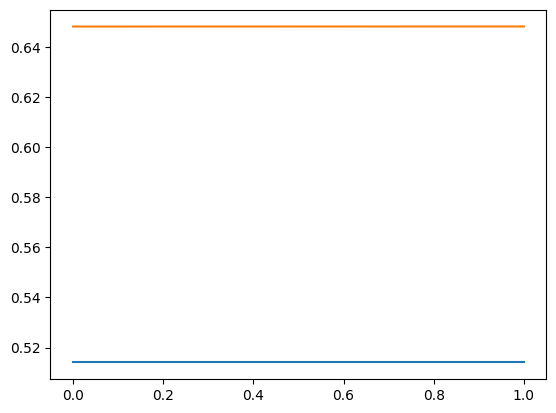

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

Ridge Regression

In [ ]:
model4_ridge = Ridge(1)
model4_ridge.fit(X_train1, y_train1)
y_pred_ri = model4_ridge.predict(X_test1)

mean_squared_error(y_test1, y_pred_ri)

22621859.52585408

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_test1, y_test1)))

훈련 세트의 정확도 : 0.51
테스트 세트의 정확도 : 0.65


In [ ]:
score4_ri = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred_ri)], axis=1)
score4_ri.columns = ["test","predict"]
score4_ri

,test,predict
0,3855,7827.744457
1,11120,17459.009963
2,2153,3418.061783
3,11013,12206.398555
4,8450,5267.298310
...,...,...
263,5497,8034.302996
264,1173,-1620.460684
265,4826,6020.869379
266,12000,3678.477099


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train1, y_train1)
  train_score.append(lasso.score(X_train1, y_train1))
  test_score.append(lasso.score(X_test1, y_test1))

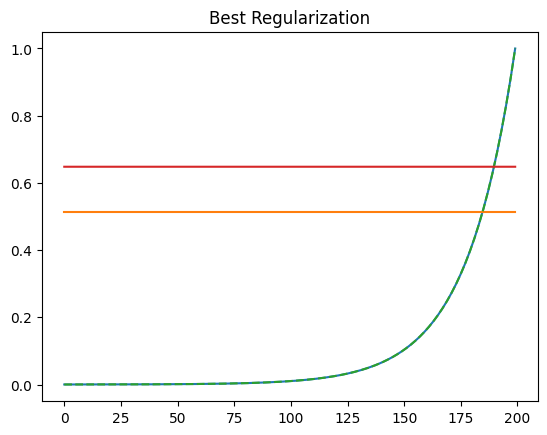

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

In [ ]:
model4_lasso = Lasso(1)
model4_lasso.fit(X_train1, y_train1)
y_pred_la = model4_lasso.predict(X_test1)

mean_squared_error(y_test1, y_pred_la)

22622587.29664766

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_test1, y_test1)))

훈련 세트의 정확도 : 0.51
테스트 세트의 정확도 : 0.65


In [ ]:
score4_la = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred_la)], axis=1)
score4_la.columns = ["test","predict"]
score4_la

,test,predict
0,3855,7827.790664
1,11120,17460.812894
2,2153,3417.611805
3,11013,12206.965563
4,8450,5266.788146
...,...,...
263,5497,8035.593472
264,1173,-1624.678973
265,4826,6021.815195
266,12000,3675.293164


#### Model 4_2 (Ridge, Lasso)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train2, y_train2)
  train_score.append(ridge.score(X_train2, y_train2))
  test_score.append(ridge.score(X_test2, y_test2))

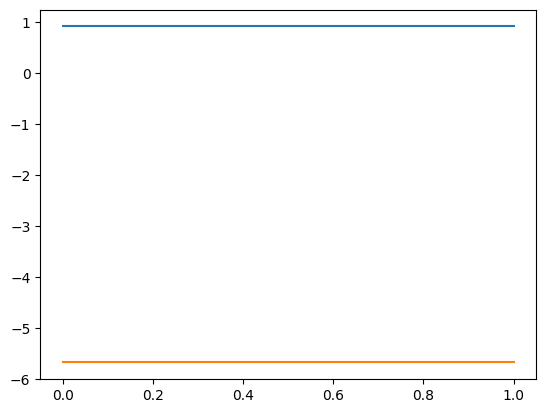

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

Ridge Regression

In [ ]:
model4_2_ridge = Ridge(1)
model4_2_ridge.fit(X_train2, y_train2)
y_pred_ri = model4_2_ridge.predict(X_test2)

mean_squared_error(y_test2, y_pred_ri)

739426718.5398556

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_test2, y_test2)))

훈련 세트의 정확도 : 0.91
테스트 세트의 정확도 : -5.68


In [ ]:
score4_2_ri = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred_ri)], axis=1)
score4_2_ri.columns = ["test","predict"]
score4_2_ri

,test,predict
0,9821,-5345.116760
1,6600,5083.601273
2,2000,2365.453192
3,20028,19170.573159
4,3300,-1077.008786
...,...,...
263,13373,3924.516684
264,14619,21188.151327
265,2380,1859.577301
266,100,2216.996865


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train2, y_train2)
  train_score.append(lasso.score(X_train2, y_train2))
  test_score.append(lasso.score(X_test2, y_test2))

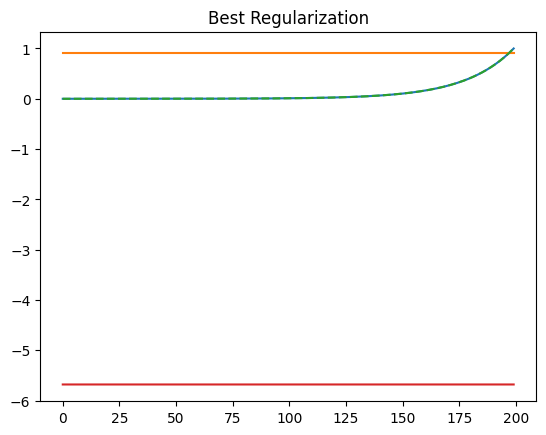

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

In [ ]:
model4_2_lasso = Lasso(1)
model4_2_lasso.fit(X_train2, y_train2)
y_pred_la = model4_2_lasso.predict(X_test2)

mean_squared_error(y_test2, y_pred_la)

739418542.947896

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_test2, y_test2)))

훈련 세트의 정확도 : 0.91
테스트 세트의 정확도 : -5.68


In [ ]:
score4_2_la = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred_la)], axis=1)
score4_2_la.columns = ["test","predict"]
score4_2_la

,test,predict
0,9821,-5341.180007
1,6600,5085.125251
2,2000,2364.678984
3,20028,19173.387696
4,3300,-1074.219003
...,...,...
263,13373,3925.899413
264,14619,21188.628938
265,2380,1858.582874
266,100,2200.949851


#### Model 5_1 (SVM regressor)
- 변수: 공연장소, 공연유형, 신청인원, vector3_col

In [ ]:
# !pip install bayesian-optimization

In [ ]:
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# SVM 회귀 모델에 대한 최적의 파라미터 탐색

def svr_cv(C, gamma):
    model = SVR(C = C, gamma = gamma, kernel = 'rbf')
    model.fit(X_train1, y_train1)
    y_pred_svr1 = model.predict(X_val1)
    mse = mean_squared_error(y_val1, y_pred_svr1)
    r2 = r2_score(y_val1, y_pred_svr1)
    return r2

pbounds = {'C': (0.01, 1e+04), 'gamma': (1e-8, 1e+1)}
optimizer = BayesianOptimization(f = svr_cv, pbounds = pbounds)
optimizer.maximize(init_points = 5, n_iter = 20)

print("Best Parameters: ", optimizer.max)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | -0.05274  | 4.912e+03 | 1.983     |
| 2         | -0.08406  | 2.904e+03 | 2.044     |
| 3         | -0.07454  | 3.626e+03 | 2.031     |
| 4         | -0.09942  | 990.1     | 4.866     |
| 5         | -0.1052   | 178.2     | 7.873     |
| 6         | -0.05212  | 4.978e+03 | 3.886     |
| 7         | -0.01436  | 9.3e+03   | 0.2437    |
| 8         | -0.01216  | 9.999e+03 | 1.213     |
| 9         | -0.01444  | 9.769e+03 | 9.746     |
| 10        | -0.02     | 7.706e+03 | 0.02225   |
| 11        | -0.02051  | 8.509e+03 | 9.195     |
| 12        | -0.03011  | 6.822e+03 | 0.1903    |
| 13        | -0.01343  | 9.999e+03 | 8.06      |
| 14        | -0.03854  | 6.036e+03 | 1.412     |
| 15        | -0.02824  | 7.294e+03 | 8.013     |
| 16        | 0.7706    | 8.918e+03 | 1e-08     |
| 17        | -0.01461  | 8.918e+03 | 0.04559   |
| 18        | -0.07581  | 3.565e+03 | 5.86      |


In [ ]:
model5_1 = SVR(kernel = 'rbf', C = 1e+04, gamma = 1e-08)
model5_1.fit(X_train1, y_train1)

y_pred_svr1 = model5_1.predict(X_test1)

mse = mean_squared_error(y_test1, y_pred_svr1)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 26838883.704116587


In [ ]:
score5_1 = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred_svr1)], axis = 1)
score5_1.columns = ["test", "predict"]
score5_1

,test,predict
0,3855,3449.551945
1,11120,18585.483068
2,2153,3495.593132
3,11013,19246.673242
4,8450,7021.905089
...,...,...
263,5497,4579.504700
264,1173,314.958530
265,4826,4707.791739
266,12000,10627.598135


#### Model 5_2 (SVM regressor)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
# SVM 회귀 모델에 대한 최적의 파라미터 탐색

def svr_cv(C, gamma):
    model = SVR(C = C, gamma = gamma, kernel = 'rbf')
    model.fit(X_train2, y_train2)
    y_pred_svr2 = model.predict(X_val2)
    mse = mean_squared_error(y_val2, y_pred_svr2)
    rmse = np.sqrt(mean_squared_error(y_val2, y_pred_svr2))
    r2 = r2_score(y_val2, y_pred_svr2)
    return r2

pbounds = {'C': (0.01, 1e+03), 'gamma': (1e-8, 1e+1)}
optimizer = BayesianOptimization(f = svr_cv, pbounds = pbounds)
optimizer.maximize(init_points = 5, n_iter = 20)

print("Best Parameters: ", optimizer.max)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | -0.2237   | 936.8     | 1.769     |
| 2         | -0.231    | 236.9     | 7.55      |
| 3         | -0.23     | 361.1     | 9.966     |
| 4         | -0.2272   | 547.4     | 5.948     |
| 5         | -0.231    | 60.04     | 6.913     |
| 6         | -0.2234   | 999.7     | 9.783     |
| 7         | -0.2234   | 1e+03     | 0.6894    |
| 8         | -0.2234   | 998.3     | 9.907     |
| 9         | -0.2234   | 999.8     | 1.394     |
| 10        | -0.2234   | 999.8     | 8.75      |
| 11        | -0.2234   | 999.9     | 9.599     |
| 12        | -0.2249   | 999.9     | 0.006102  |
| 13        | -0.2237   | 941.0     | 2.029     |
| 14        | -0.2237   | 940.6     | 6.21      |
| 15        | -0.2237   | 936.8     | 5.528     |
| 16        | -0.2236   | 945.0     | 4.248     |
| 17        | -0.2236   | 945.4     | 8.789     |
| 18        | -0.2236   | 948.7     | 6.431     |


In [ ]:
model5_2 = SVR(kernel = 'rbf', C = 1e+04, gamma = 1e-08)
model5_2.fit(X_train2, y_train2)

y_pred_svr2 = model5_2.predict(X_test2)

mse = mean_squared_error(y_test2, y_pred_svr2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 42827300.90645951


In [ ]:
score5_2 = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred_svr2)], axis = 1)
score5_2.columns = ["test", "predict"]
score5_2

,test,predict
0,9821,8732.310683
1,6600,5517.235728
2,2000,2008.853375
3,20028,16399.796493
4,3300,907.946059
...,...,...
263,13373,3966.209976
264,14619,17514.853634
265,2380,1735.015857
266,100,1018.433904


#### 성능지표

 인터뷰 "예측인원이 실제 인원의 10% 오차 범위에 있다면 사용할 것 같다"에 기반하여 지표 생성하고자 함.

In [ ]:
# model1(평균)의 mse:
# model2(회귀분석)의 mse: 793867767.5693338
# model2_2(회귀분석)의 mse: 27340412.68470268
# model3_1(ANN)의 mse: 243047358.3719119
# model3_2(ANN)의 mse: 67250180.27948111
# model4_1(Ridge)의 mse: 967757364.262466
# model4_1(Lasso)의 mse: 967747731.1896203
# model4_2(Ridge)의 mse: 49465833.452588834
# model4_2(Lasso)의 mse: 49465462.11781541
# model5_1(SVR)의 mse: 30549172.924209498
# model5_2(SVR)의 mse: 42421915.2770245

오차범위계산 함수 (예측 인원이 실제 인원의 10% 오차 범위에 있는지 여부)

In [ ]:
def Error_fun(df, real, predict):
  df["pre_success"] = (df[predict] >= df[real]*0.9) & (df[predict] <= df[real]*1.1)
  return len(df.loc[df["pre_success"] == True])/len(df) # 예측 퍼센트 도출

In [ ]:
Error_fun(score2_df,"test","predict")

0.19402985074626866

In [ ]:
Error_fun(score2_2_df,"test","predict")

0.04868913857677903

In [ ]:
Error_fun(score3_df,"test","predict")

0.13059701492537312

In [ ]:
Error_fun(score4_la,"test","predict")

0.17164179104477612

In [ ]:
Error_fun(score4_ri,"test","predict")

0.17164179104477612

In [ ]:
Error_fun(score4_2_la,"test","predict")

0.1044776119402985

In [ ]:
Error_fun(score4_2_ri,"test","predict")

0.1044776119402985

In [ ]:
Error_fun(score5_1,"test","predict")

0.22761194029850745

In [ ]:
Error_fun(score5_2,"test","predict")

0.208955223880597

#### 가중평균
예측 성공률 상위 3개의 모델을 이용하여 베이지안 최적화를 통해 최적의 가중치를 찾아 가중평균을 구한다.

첫번째 변수(공연장소, 공연유형, 신청인원, vector3_col)

In [ ]:
def weighted_average1(weights_1, weights_2, weights_3):
    final = (score2_df['predict'] * weights_1) + (score4_la['predict'] * weights_2) + (score5_1['predict'] * weights_3)
    score = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(final)], axis = 1)
    score.columns = ["test", "predict"]
    accuracy = Error_fun(score, "test", "predict")
    return accuracy

In [ ]:
pbounds = {'weights_1': (0.0, 1.0), 'weights_2': (0.0, 1.0), 'weights_3': (0.0, 1.0)}
optimizer = BayesianOptimization(f = weighted_average1, pbounds = pbounds)
optimizer.maximize(init_points = 5, n_iter = 1000)

best_weights1 = [optimizer.max['params']['weights_1'], optimizer.max['params']['weights_2'], optimizer.max['params']['weights_3']]
best_accuracy1 = optimizer.max['target']
print("Best Weights: ", best_weights1)
print("Best accuracy: ", best_accuracy1)

|   iter    |  target   | weights_1 | weights_2 | weights_3 |
-------------------------------------------------------------
| 1         | 0.05224   | 0.5206    | 0.3337    | 0.9334    |
| 2         | 0.05597   | 0.857     | 0.3194    | 0.725     |
| 3         | 0.05597   | 0.7681    | 0.07678   | 0.9861    |
| 4         | 0.1007    | 0.336     | 0.3546    | 0.1624    |
| 5         | 0.2388    | 0.4224    | 0.5784    | 0.0771    |
| 6         | 0.1828    | 0.4618    | 0.6824    | 0.03662   |
| 7         | 0.2015    | 0.5531    | 0.5138    | 0.06164   |
| 8         | 0.2127    | 0.2449    | 0.2372    | 0.6468    |
| 9         | 0.1306    | 0.4602    | 0.6216    | 0.2522    |
| 10        | 0.02239   | 0.9688    | 0.2214    | 0.9654    |
| 11        | 0.09328   | 0.2213    | 0.621     | 0.006464  |
| 12        | 0.153     | 0.0848    | 0.1617    | 0.6394    |
| 13        | 0.04104   | 0.6031    | 0.9721    | 0.6036    |
| 14        | 0.2052    | 0.3301    | 0.109     | 0.5667    |
| 15    

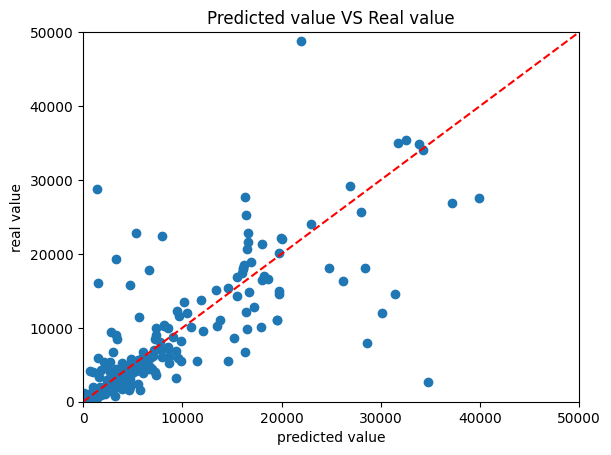

In [ ]:
final1 = (score2_df['predict'] * 0.034) + (score4_la['predict'] * 0.138) + (score5_1['predict'] * 0.899)
score1 = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(final1)], axis = 1)
score1.columns = ["test", "predict"]

plt.scatter(score1['predict'], score1['test'])
a = np.linspace(0, 50000, 100)
b = a
plt.plot(a, b, color = 'red', linestyle = '--') # predicted = real 직선
plt.xlim([0, 50000])
plt.ylim([0, 50000])
plt.title('Predicted value VS Real value')
plt.xlabel('predicted value')
plt.ylabel('real value')
plt.show()

In [ ]:
mean_squared_error(y_test1, final1)

23972780.514581263

두번째 변수(공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col)

In [ ]:
def weighted_average2(weights_1, weights_2, weights_3):
    final = (score3_df['predict'] * weights_1) + (score4_2_la['predict'] * weights_2) + (score5_2['predict'] * weights_3)
    score = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(final)], axis = 1)
    score.columns = ["test", "predict"]
    accuracy = Error_fun(score, "test", "predict")
    return accuracy

In [ ]:
pbounds = {'weights_1': (0.0, 1.0), 'weights_2': (0.0, 1.0), 'weights_3': (0.0, 1.0)}
optimizer = BayesianOptimization(f = weighted_average2, pbounds = pbounds)
optimizer.maximize(init_points = 5, n_iter = 1000)

best_weights2 = [optimizer.max['params']['weights_1'], optimizer.max['params']['weights_2'], optimizer.max['params']['weights_3']]
best_accuracy2 = optimizer.max['target']
print("Best Weights: ", best_weights2)
print("Best accuracy: ", best_accuracy2)

|   iter    |  target   | weights_1 | weights_2 | weights_3 |
-------------------------------------------------------------
| 1         | 0.03731   | 0.7055    | 0.9273    | 0.2122    |
| 2         | 0.02612   | 0.8084    | 0.4768    | 0.625     |
| 3         | 0.1194    | 0.4702    | 0.5131    | 0.1663    |
| 4         | 0.1157    | 0.0866    | 0.4373    | 0.2018    |
| 5         | 0.02239   | 0.8793    | 0.5555    | 0.6201    |
| 6         | 0.08955   | 0.3733    | 0.1083    | 0.0       |
| 7         | 0.1194    | 0.4713    | 0.4977    | 0.1809    |
| 8         | 0.09701   | 0.0       | 0.9467    | 0.0       |
| 9         | 0.2164    | 0.009228  | 0.04911   | 0.9886    |
| 10        | 0.08582   | 0.0       | 0.4058    | 1.0       |
| 11        | 0.1269    | 0.0       | 0.0       | 0.7583    |
| 12        | 0.04478   | 0.5465    | 0.5886    | 0.7435    |
| 13        | 0.1343    | 0.1827    | 0.0       | 1.0       |
| 14        | 0.007463  | 0.947     | 0.8372    | 0.8155    |
| 15    

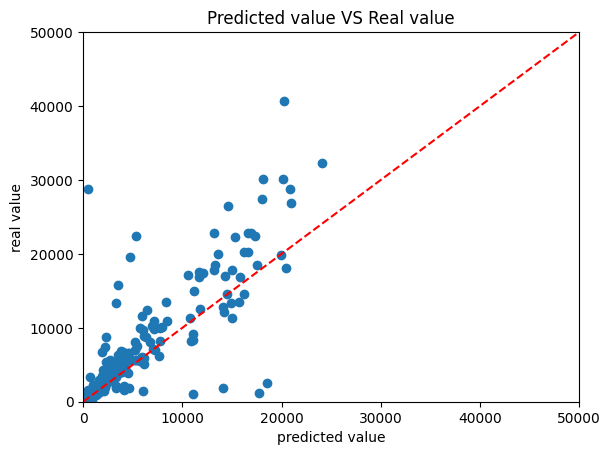

In [ ]:
final2 = (score3_df['predict'] * 0.127) + (score4_2_la['predict'] * 0.006) + (score5_2['predict'] * 0.819)
score2 = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(final2)], axis = 1)
score2.columns = ["test", "predict"]

plt.scatter(score2['predict'], score2['test'])
a = np.linspace(0, 50000, 100)
b = a
plt.plot(a, b, color = 'red', linestyle = '--') # predicted = real 직선
plt.xlim([0, 50000])
plt.ylim([0, 50000])
plt.title('Predicted value VS Real value')
plt.xlabel('predicted value')
plt.ylabel('real value')
plt.show()

In [ ]:
mean_squared_error(y_test2, final2)

29060539.483224414